# Using combined precompiled weights to train model

Need to download precompiled weights and place them in the directory specified by keras

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras import optimizers, regularizers, applications,Input
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.models import Sequential , Model
from tensorflow.python.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,Concatenate

from keras.utils import to_categorical

plt.style.use('ggplot')
plt.switch_backend('agg')

%matplotlib inline

In [3]:
import os
from tensorflow.python.client import device_lib

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"      #GPU

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4366369404466154377
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6620742943
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15493909141878063857
physical_device_desc: "device: 0, name: GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## 1、 Parameter settings

In [2]:
EPOCHS = 30
BATCH_SIZE = 10
img_size = 192
dropout_rate = 0.5

## 2、Construct a model of combined precompiled weights

In [4]:
def overfitting_plot(history, name):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('accuracy  '+name)
    plt.legend(loc='best')
    plt.savefig('acc_'+name+'.png')
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('loss '+name)
    plt.legend(loc='best')
    plt.savefig('loss_'+name+'.png')

def Multimodel(img_size,cnn_weights_path=None,all_weights_path=None,class_num=25,cnn_no_vary=False):
    '''Combination of densent169, xinception parallel network'''
    
    dir=os.getcwd()
    
    input_layer=Input(shape=(img_size,img_size,3))
    dense=applications.DenseNet169(include_top=False,weights=None,input_tensor=input_layer,input_shape=(img_size,img_size,3))
    xception=applications.Xception(include_top=False,weights=None,input_tensor=input_layer,input_shape=(img_size,img_size,3))
    
    if cnn_no_vary:
        for i,layer in  enumerate(dense.layers):
            dense.layers[i].trainable=False
        for i,layer in enumerate(xception.layers):
            xception.layers[i].trainable=False
        
    if cnn_weights_path!=None:
        dense.load_weights(cnn_weights_path[0])
        xception.load_weights(cnn_weights_path[1])
 
    dense=dense(input_layer)
    xception=xception(input_layer)  
    
    #Global maximum pooling for dense_169 and xception
    top1_model=GlobalAveragePooling2D(input_shape=(7,7,1024),data_format='channels_last')(dense)
    top2_model=GlobalAveragePooling2D(input_shape=(7,7,1024),data_format='channels_last')(xception)
    
    #print(top1_model.shape,top2_model.shape)
    #Connect top1_model and top2_model
    t=Concatenate(axis=1)([top1_model,top2_model])
    #The first fully connected layer
    top_model=Dense(units=512,activation="relu")(t)
    top_model=Dropout(rate=0.5)(top_model)
    
    top_model=Dense(units=class_num,activation="softmax")(top_model)
    
    model=Model(inputs=input_layer,outputs=top_model)
    
    #Load all parameters
    if all_weights_path:
        model.load_weights(all_weights_path)
    
    return model

def newtrain(img_size,epochs):
    X_train='X_train%dN.npy'%(img_size)
    y_train='y_train%dN.npy'%(img_size)
    X_test='X_test%dN.npy'%(img_size)
    y_test='y_test%dN.npy'%(img_size)

    Xtrain=np.load(X_train)
    Ytrain=np.load(y_train)
    Xvalid=np.load(X_test)
    Yvalid=np.load(y_test)
    
    #The location of the following two pre-compiled weight files should be changed according to your computer
    weights_path=["C:/Users/wangPC/.keras/models/densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5","C:/Users/wangPC/.keras/models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"]
    
    model=Multimodel(img_size,cnn_weights_path=weights_path,class_num=25)
    model.summary()
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.RMSprop(lr=1e-5), 
                  metrics=['acc'])
    
    trained_model = model.fit(Xtrain, Ytrain, epochs = epochs, shuffle = True, batch_size = BATCH_SIZE,validation_data=(Xvalid, Yvalid))
    
    print(img_size,'Training completed！')
    title=str(img_size)
    overfitting_plot(trained_model, title)
    
    model.save('mynewmodel.h5')
    
    return model

## 3、Training model
To set the image size to 224, you must first preprocess the image data of this size.

Only 10 iterations below, you can increase the number

W0815 22:47:55.445975 31328 deprecation.py:506] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet169 (Model)             (None, 7, 7, 1664)   12642880    input_1[0][0]                    
__________________________________________________________________________________________________
xception (Model)                (None, 7, 7, 2048)   20861480    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1664)         0           densenet169[1][0]                
______________________________________________________________________________________________

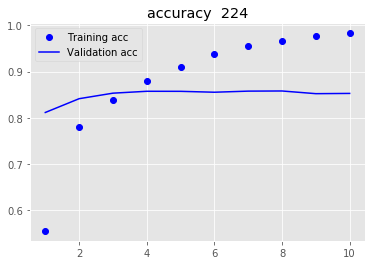

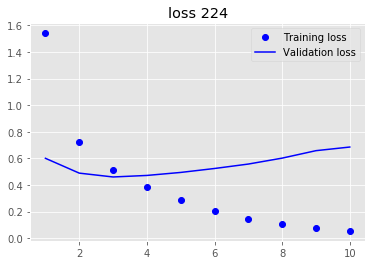

In [5]:
model=newtrain(224,10)

## 4、Model evaluation

In [7]:
#Load test data
img_size=224
X_test='X_test%dN.npy'%(img_size)
y_test='y_test%dN.npy'%(img_size)

Xvalid=np.load(X_test)
Yvalid=np.load(y_test)

In [10]:
num_classes = 25
y_pred = model.predict(Xvalid)
# Convert one-hot to index
y_pred = np.argmax(y_pred, axis=1)
y_pred = to_categorical(y_pred, num_classes)

#Print classification report
from sklearn.metrics import classification_report
print(classification_report(Yvalid, y_pred))

             precision    recall  f1-score   support

          0       0.87      0.93      0.90       214
          1       0.88      0.87      0.87       204
          2       0.87      0.87      0.87       229
          3       0.87      0.86      0.87       217
          4       0.96      0.96      0.96       965
          5       0.89      0.93      0.91       177
          6       0.77      0.81      0.79       562
          7       0.80      0.76      0.78       240
          8       0.94      0.89      0.91      1288
          9       0.86      0.83      0.84       303
         10       0.98      0.95      0.96       269
         11       0.76      0.79      0.77       675
         12       0.77      0.84      0.80       323
         13       0.74      0.76      0.75       268
         14       0.97      0.93      0.95       207
         15       0.85      0.79      0.82       190
         16       0.85      0.92      0.88       202
         17       0.96      0.93      0.95   